# Face Detection with Transfer Learning

#### Using transfer learning of an object detector model to detect faces in a given image 

Solution Approach: 

1. Reuse MobileNet model. 
2. Reuse functions for batch generation, loss function and bounding box utilities. 
3. Use WIDER FACE dataset for training the model. 
4. Explore image label information and load train and test data. 
5. Initiate MobileNet model and freeze layers for transfer learning. 
6. Load model weights. 
7. Prepare training and validation batch generators. 
8. Initilaize Hyper Parameters learning rate, epochs, optimizer and loss function. 
9. Add early stopping and model checkpoint layers on validation loss with some patience values. 
10. Train the model on data generated batch-by-batch. 
11. Load the best saved model with best Validation accuracy. 
12. Plot the bounding box in the test image to show the predictions. 
13. Create a folder and get the predictions for the test images. 
14. Visualize a test image to check predictions. 
15. Try bounding box prediction with different values of confidence threshold. 
16. Conclusions 

##### Extract all the files to the current working directory

In [1]:
files_zip_path = "C:/Users/LENOVO/Files_required_for_face_detection.zip"

import zipfile
#This extracts the files to the current working directory
archive = zipfile.ZipFile(files_zip_path, 'r')
archive.extractall()

##### Import MobileNet model 

In [2]:
### Import MobileNet model from mn_model.py

from mn_model import mn_model

Using TensorFlow backend.


##### Import the BatchGenerator and SSDLoss functions 

In [3]:
#Import the BatchGenerator and SSDLoss functions 

import warnings
warnings.filterwarnings("ignore")

from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

In [4]:
from keras.optimizers import Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.callbacks import Callback
from keras import backend as K 
from keras.models import load_model
from math import ceil 
import numpy as np 
from termcolor import colored

# training parameters
from keras import backend as K
import scipy.misc as sm

# Display 
import imageio
import matplotlib.pyplot as plt
%matplotlib inline


##### Set the parameters for the model

Set n_classes (no.of classes) = 2, as we are interested in only face detection 
Set class_names = ["background", "face"], as there are two classes - face and background

In [5]:
img_height =512
img_width = 512

img_channels = 3

n_classes =2 
class_names = ["background","face"]

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # anchorboxes for coco dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True

#Path where you want to save the weights, model and checkpoints
det_model_path = "C:/Users/LENOVO/Face_Detection/"

##### Import the dataset for the model to train on - WIDER FACE dataset

In [6]:
project_path = "C:/Users/LENOVO/Face_Detection/"

In [7]:
train_images_path = project_path + 'WIDER_train.zip'
test_images_path = project_path + 'WIDER_val.zip'

In [8]:
import zipfile
#This extracts the files to the current working directory
archive = zipfile.ZipFile(train_images_path, 'r')
archive.extractall()

In [9]:
archive = zipfile.ZipFile(test_images_path, 'r')
archive.extractall()

##### Get the labels for these images to be used for training for detecting faces 

Load the  `wider_train_small.npy` file given to check the information given about the dataset with following elements:
        1.   Image filename (str)
        2.   Image filename (str)
        3.   Image size (list) [height, width]
        4.   List of bounding box co-ordinates and Class label (list) [[a,b,c,d], Class label, ...]
        
        where,
        a,b,c,d are the four co-ordinates of the bounding box
        Class label is the position of object as mentioned in `class_names` list above.

In [10]:
data = np.load('C:/Users/LENOVO/Face_Detection/wider_train_small.npy', allow_pickle=True).item()

In [11]:
### Printed first element to check the above given information.

for key in data:
    print(key)
    print(data[key])
    #Breaking after printing first key and its value
    break

52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg
['WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', 'WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', [300, 300], [[21, 667, 9, 655], 1]]


##### Load the files `wider_train.npy` and `wider_val.npy`

In [12]:
train_data = 'C:/Users/LENOVO/Face_Detection/wider_train_small.npy'
test_data = 'C:/Users/LENOVO/Face_Detection/wider_val_small.npy'

x = np.load(train_data, allow_pickle=True)

##### Initiate the model for transfer learning 


In [13]:
# build the keras model

K.clear_session()
#The following function returns you multiple things. The "model" is the Keras model that has to be trained 
model, model_layer, img_input, predictor_sizes = mn_model(image_size=(img_height, img_width, img_channels), 
                                                                      n_classes = n_classes,
                                                                      min_scale = None, 
                                                                      max_scale = None, 
                                                                      scales = scales, 
                                                                      aspect_ratios_global = None, 
                                                                      aspect_ratios_per_layer = aspect_ratios, 
                                                                      two_boxes_for_ar1= two_boxes_for_ar1, 
                                                                      limit_boxes=limit_boxes, 
                                                                      variances= variances, 
                                                                      coords=coords, 
                                                                      normalize_coords=normalize_coords)

model.summary()  #Un-comment this line to view the details of the model and all layers present in the model 


====> Model Specific data
====> Height, Width, Channels : 512 512 3
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda1 (Lambda)                (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda2 (Lambda)                (None, 512, 512, 3)  0           lambda1[0][0]                    
__________________________________________________________________________________________________
lambda3 (Lambda)                (None, 512, 512, 3)  0           lam

conv_dw_13 (DepthwiseConv2D)    (None, 16, 16, 1024) 9216        conv_pw_12_relu[0][0]            
__________________________________________________________________________________________________
conv_dw_13_bn (BatchNormalizati (None, 16, 16, 1024) 4096        conv_dw_13[0][0]                 
__________________________________________________________________________________________________
conv_dw_13_relu (Activation)    (None, 16, 16, 1024) 0           conv_dw_13_bn[0][0]              
__________________________________________________________________________________________________
conv_pw_13 (Conv2D)             (None, 16, 16, 1024) 1048576     conv_dw_13_relu[0][0]            
__________________________________________________________________________________________________
conv_pw_13_bn (BatchNormalizati (None, 16, 16, 1024) 4096        conv_pw_13[0][0]                 
__________________________________________________________________________________________________
conv_pw_13

detection_conv7_2_mbox_loc_conv (None, 4, 4, 256)    0           detection_conv7_2_mbox_loc_conv_d
__________________________________________________________________________________________________
detection_conv8_2_mbox_loc_conv (None, 2, 2, 256)    0           detection_conv8_2_mbox_loc_conv_d
__________________________________________________________________________________________________
detection_conv9_2_mbox_loc_conv (None, 1, 1, 256)    0           detection_conv9_2_mbox_loc_conv_d
__________________________________________________________________________________________________
detection_conv4_3_norm_mbox_con (None, 32, 32, 8)    32          detection_conv4_3_norm_mbox_conf_
__________________________________________________________________________________________________
detection_fc7_mbox_conf_conv_pw (None, 16, 16, 12)   48          detection_fc7_mbox_conf_conv_pw_2
__________________________________________________________________________________________________
detection_

##### Freeze all the layers in the above model with names not having `detection` word as prefix

In [14]:
#Freezing layers in the model which don't have 'detection' in their name
for layer in model.layers:
  if('detection' not in layer.name): #prefix detection to freeze layers which does not have 'detection'
    #Freezing a layer
    layer.trainable = False

#Module to print colourful statements
from termcolor import colored

#Check which layers have been frozen 
for layer in model.layers:
  print (colored(layer.name, 'blue'))
  print (colored(layer.trainable, 'red'))

input_1
False
lambda1
False
lambda2
False
lambda3
False
conv1
False
conv1_bn
False
conv1_relu
False
conv_dw_1
False
conv_dw_1_bn
False
conv_dw_1_relu
False
conv_pw_1
False
conv_pw_1_bn
False
conv_pw_1_relu
False
conv_dw_2
False
conv_dw_2_bn
False
conv_dw_2_relu
False
conv_pw_2
False
conv_pw_2_bn
False
conv_pw_2_relu
False
conv_dw_3
False
conv_dw_3_bn
False
conv_dw_3_relu
False
conv_pw_3
False
conv_pw_3_bn
False
conv_pw_3_relu
False
conv_dw_4
False
conv_dw_4_bn
False
conv_dw_4_relu
False
conv_pw_4
False
conv_pw_4_bn
False
conv_pw_4_relu
False
conv_dw_5
False
conv_dw_5_bn
False
conv_dw_5_relu
False
conv_pw_5
False
conv_pw_5_bn
False
conv_pw_5_relu
False
conv_dw_6
False
conv_dw_6_bn
False
conv_dw_6_relu
False
conv_pw_6
False
conv_pw_6_bn
False
conv_pw_6_relu
False
conv_dw_7
False
conv_dw_7_bn
False
conv_dw_7_relu
False
conv_pw_7
False
conv_pw_7_bn
False
conv_pw_7_relu
False
conv_dw_8
False
conv_dw_8_bn
False
conv_dw_8_relu
False
conv_pw_8
False
conv_pw_8_bn
False
conv_pw_8_relu
False
conv

##### Load the weights of the model given in file `mobilenet_1_0_224_tf.h5`
Parameter 'by_name=True' ensures that the weights are only loaded for the names present in both the weights file and the model. 

In [15]:
model.load_weights('mobilenet_1_0_224_tf.h5', by_name=True)

##### Prepare training and validation batch generator  

In [16]:
batch_size = 32
ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

train_dataset = BatchGenerator(images_path=train_data, 
                include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==>TRAINING DATA")
print ("==> Parsing XML files ...")

train_dataset.parse_xml(
                  annotations_path=train_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)
print("==>Parsing XML Finished.")

print ("==>Generate training batches...")
train_generator = train_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=True,
                 brightness=(0.5,2,0.5),
                 flip=0.5,
                 translate=((0, 20), (0, 30), 0.5),
                 scale=(0.75, 1.2, 0.5),
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False,
                 resize=(img_height, img_width),
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print ("==>Training batch generation complete")

n_train_samples = train_dataset.get_n_samples()

print ("==>Total number of training samples = {}".format(n_train_samples))

# Now repeat above steps for validation data 

print ("==>VALIDATION")

val_dataset = BatchGenerator(images_path=test_data, include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==> Parsing XML files ...")


val_dataset.parse_xml(
                  annotations_path=test_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)


print("==>Parsing XML Finished.")


print ("==>Generate training batches...")
val_generator = val_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False, 
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)


print ("==>Training batch generation complete")

n_val_samples = val_dataset.get_n_samples()

print ("==>Total number of validation samples = {}".format(n_val_samples))

==>TRAINING DATA
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of training samples = 128
==>VALIDATION
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of validation samples = 60


##### Initilaize Hyper Parameters learning rate, epochs, optimizer and loss function

In [17]:
# setting up training 

# batch_size and no.of epochs

batch_size = 16
num_epochs = 50

#Learning rate
base_lr = 0.001

# Optimizer
adam = Adam(lr=base_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay = 0.0)

# Loss
ssd_loss = SSDLoss(neg_pos_ratio=2, n_neg_min=0, alpha=1.0, beta = 1.0)

# Compile
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


##### Add early stopping and model checkpoint layers on validation loss with some patience values 
Using checkpoint to save the best model based on validation accuracy.

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights = True)

mc = ModelCheckpoint("C:/Users/LENOVO/Face_Detection/Face_Detection_best_model.h5", monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

callbacks_list = [es,mc]

##### Train the model on data generated batch-by-batch by a Python generator, `train_generator` object as generator.

In [19]:
H = model.fit_generator(
train_generator,
steps_per_epoch=n_train_samples // batch_size,
validation_data=val_generator,
validation_steps=n_val_samples // batch_size,
epochs=num_epochs,
callbacks=callbacks_list)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/50
8/8 [==============================] - ETA: 8:44 - loss: 0.419 - ETA: 6:02 - loss: 0.402 - ETA: 4:37 - loss: 0.390 - ETA: 3:32 - loss: 0.390 - ETA: 2:34 - loss: 0.389 - ETA: 1:41 - loss: 0.381 - ETA: 49s - loss: 0.377 - 509s 64s/step - loss: 0.3698 - val_loss: 0.3950

Epoch 00001: val_loss improved from inf to 0.39498, saving model to C:/Users/LENOVO/Face_Detection/Face_Detection_best_model.h5
Epoch 2/50
8/8 [==============================] - ETA: 5:21 - loss: 0.301 - ETA: 4:35 - loss: 0.332 - ETA: 3:48 - loss: 0.324 - ETA: 3:02 - loss: 0.328 - ETA: 2:16 - loss: 0.327 - ETA: 1:31 - loss: 0.328 - ETA: 45s - loss: 0.322 - 473s 59s/step - loss: 0.3214 - val_loss: 0.3826

Epoch 00002: val_loss improved from 0.39498 to 0.38264, saving model to C:/Users/LENOVO/Face_Detection/Face_Detection_best_model.h5
Epoch 3/50
8/8 [==============================] - ETA: 5:27 - loss: 0.298 - ETA: 4:37 - loss: 0.295 - 


Epoch 00044: val_loss did not improve from 0.21425
Epoch 45/50
8/8 [==============================] - ETA: 6:34 - loss: 0.195 - ETA: 5:35 - loss: 0.196 - ETA: 4:38 - loss: 0.196 - ETA: 3:42 - loss: 0.193 - ETA: 2:47 - loss: 0.191 - ETA: 1:51 - loss: 0.193 - ETA: 55s - loss: 0.199 - 578s 72s/step - loss: 0.1953 - val_loss: 0.2202

Epoch 00045: val_loss did not improve from 0.21425
Epoch 46/50
8/8 [==============================] - ETA: 6:32 - loss: 0.181 - ETA: 5:33 - loss: 0.190 - ETA: 4:36 - loss: 0.192 - ETA: 3:41 - loss: 0.196 - ETA: 2:45 - loss: 0.199 - ETA: 1:50 - loss: 0.202 - ETA: 55s - loss: 0.201 - 569s 71s/step - loss: 0.2002 - val_loss: 0.2223

Epoch 00046: val_loss did not improve from 0.21425
Epoch 47/50
8/8 [==============================] - ETA: 6:26 - loss: 0.202 - ETA: 5:30 - loss: 0.184 - ETA: 4:35 - loss: 0.203 - ETA: 3:40 - loss: 0.196 - ETA: 2:45 - loss: 0.198 - ETA: 1:49 - loss: 0.196 - ETA: 54s - loss: 0.199 - 572s 72s/step - loss: 0.1966 - val_loss: 0.2192

Epo

##### Load the best saved model with best Validation accuracy

In [20]:
model.load_weights("C:/Users/LENOVO/Face_Detection/Face_Detection_best_model.h5")

##### Plot the bounding box in the test image to show the predictions

In [21]:
def save_bb(path, filename, results, prediction=True):
  
  # print filename

  img = image.load_img(filename, target_size=(img_height, img_width))
  img = image.img_to_array(img)

  filename = filename.split("/")[-1]

  if(not prediction):
    filename = filename[:-4] + "_gt" + ".jpg"

  #fig,currentAxis = plt.subplots(1)
  currentAxis = plt.gca()

 # Get detections with confidence higher than 0.6.
  colors = plt.cm.hsv(np.linspace(0, 1, len(results))).tolist()
  color_code = len(results)
  print (colored("total number of bbs: %d" % len(results), "yellow"))
  for result in results:
    # Parse the outputs.

    if(prediction):
      det_label = result[0]
      det_conf = result[1]
      det_xmin = result[2]
      det_xmax = result[3]
      det_ymin = result[4]
      det_ymax = result[5]
    else :
      det_label = result[0]
      det_xmin = result[1]
      det_xmax = result[2]
      det_ymin = result[3]
      det_ymax = result[4]

    xmin = int(det_xmin)
    ymin = int(det_ymin)
    xmax = int(det_xmax)
    ymax = int(det_ymax)

    if(prediction):
      score = det_conf
    
    plt.imshow(img / 255.)
    
    label = int(int(det_label))
    label_name = class_names[label]
    # print label_name 
    # print label

    if(prediction):
      display_txt = '{:0.2f}'.format(score)
    else:
      display_txt = '{}'.format(label_name)

      
    # print (xmin, ymin, ymin, ymax)
    coords = (xmin, ymin), (xmax-xmin), (ymax-ymin)
    color_code = color_code-1 
    color = colors[color_code]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.2})

  # y
  currentAxis.axes.get_yaxis().set_visible(False)
  # x
  currentAxis.axes.get_xaxis().set_visible(False)
  plt.savefig(path + filename, bbox_inches='tight')

  print ('saved' , path + filename)

  plt.clf()


##### Create a folder and get the predictions for the test images 

In [22]:
!mkdir output_test

In [23]:
from keras.preprocessing import image
from matplotlib import pyplot as plt

test_size = 16
test_generator = val_dataset.generate(
                 batch_size=test_size,
                 train=False,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print (colored("done.", "green"))

print (colored("now predicting...", "yellow"))

_CONF = 0.63 
_IOU = 0.15

for j in range(test_size):
  X, y, filenames = next(test_generator)
  num_files = len(filenames)

  y_pred = model.predict(X)


  y_pred_decoded = decode_y2(y_pred,
                             confidence_thresh=_CONF,
                            iou_threshold=_IOU,
                            top_k='all',
                            input_coords=coords,
                            normalize_coords=normalize_coords,
                            img_height=img_height,
                            img_width=img_width)


  np.set_printoptions(suppress=True)
  
  for i in range(num_files):
    save_bb("C:/Users/LENOVO/Face_Detection/output_test/", filenames[i], y_pred_decoded[i])
    save_bb("C:/Users/LENOVO/Face_Detection/output_test/", filenames[i], y[i], prediction=False)


done.
now predicting...
total number of bbs: 0
saved C:/Users/LENOVO/Face_Detection/output_test/26_Soldier_Drilling_Soldiers_Drilling_26_393.jpg
total number of bbs: 5
saved C:/Users/LENOVO/Face_Detection/output_test/26_Soldier_Drilling_Soldiers_Drilling_26_393_gt.jpg
total number of bbs: 0
saved C:/Users/LENOVO/Face_Detection/output_test/41_Swimming_Swimmer_41_68.jpg
total number of bbs: 1
saved C:/Users/LENOVO/Face_Detection/output_test/41_Swimming_Swimmer_41_68_gt.jpg
total number of bbs: 2
saved C:/Users/LENOVO/Face_Detection/output_test/47_Matador_Bullfighter_Matador_Bullfighter_47_617.jpg
total number of bbs: 1
saved C:/Users/LENOVO/Face_Detection/output_test/47_Matador_Bullfighter_Matador_Bullfighter_47_617_gt.jpg
total number of bbs: 2
saved C:/Users/LENOVO/Face_Detection/output_test/2_Demonstration_Demonstration_Or_Protest_2_367.jpg
total number of bbs: 9
saved C:/Users/LENOVO/Face_Detection/output_test/2_Demonstration_Demonstration_Or_Protest_2_367_gt.jpg
total number of bbs:

saved C:/Users/LENOVO/Face_Detection/output_test/2_Demonstration_Demonstration_Or_Protest_2_306_gt.jpg
total number of bbs: 1
saved C:/Users/LENOVO/Face_Detection/output_test/13_Interview_Interview_Sequences_13_779.jpg
total number of bbs: 1
saved C:/Users/LENOVO/Face_Detection/output_test/13_Interview_Interview_Sequences_13_779_gt.jpg
total number of bbs: 1
saved C:/Users/LENOVO/Face_Detection/output_test/47_Matador_Bullfighter_matadorbullfighting_47_236.jpg
total number of bbs: 27
saved C:/Users/LENOVO/Face_Detection/output_test/47_Matador_Bullfighter_matadorbullfighting_47_236_gt.jpg
total number of bbs: 2
saved C:/Users/LENOVO/Face_Detection/output_test/2_Demonstration_Political_Rally_2_219.jpg
total number of bbs: 1
saved C:/Users/LENOVO/Face_Detection/output_test/2_Demonstration_Political_Rally_2_219_gt.jpg
total number of bbs: 2
saved C:/Users/LENOVO/Face_Detection/output_test/34_Baseball_Baseball_34_608.jpg
total number of bbs: 1
saved C:/Users/LENOVO/Face_Detection/output_test

saved C:/Users/LENOVO/Face_Detection/output_test/10_People_Marching_People_Marching_2_793.jpg
total number of bbs: 10
saved C:/Users/LENOVO/Face_Detection/output_test/10_People_Marching_People_Marching_2_793_gt.jpg
total number of bbs: 2
saved C:/Users/LENOVO/Face_Detection/output_test/12_Group_Large_Group_12_Group_Large_Group_12_354.jpg
total number of bbs: 9
saved C:/Users/LENOVO/Face_Detection/output_test/12_Group_Large_Group_12_Group_Large_Group_12_354_gt.jpg
total number of bbs: 2
saved C:/Users/LENOVO/Face_Detection/output_test/34_Baseball_Baseball_34_608.jpg
total number of bbs: 1
saved C:/Users/LENOVO/Face_Detection/output_test/34_Baseball_Baseball_34_608_gt.jpg
total number of bbs: 2
saved C:/Users/LENOVO/Face_Detection/output_test/47_Matador_Bullfighter_Matador_Bullfighter_47_617.jpg
total number of bbs: 1
saved C:/Users/LENOVO/Face_Detection/output_test/47_Matador_Bullfighter_Matador_Bullfighter_47_617_gt.jpg
total number of bbs: 0
saved C:/Users/LENOVO/Face_Detection/output

saved C:/Users/LENOVO/Face_Detection/output_test/10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_674.jpg
total number of bbs: 1
saved C:/Users/LENOVO/Face_Detection/output_test/10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_674_gt.jpg
total number of bbs: 0
saved C:/Users/LENOVO/Face_Detection/output_test/12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_101.jpg
total number of bbs: 10
saved C:/Users/LENOVO/Face_Detection/output_test/12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_101_gt.jpg
total number of bbs: 3
saved C:/Users/LENOVO/Face_Detection/output_test/22_Picnic_Picnic_22_10.jpg
total number of bbs: 4
saved C:/Users/LENOVO/Face_Detection/output_test/22_Picnic_Picnic_22_10_gt.jpg
total number of bbs: 0
saved C:/Users/LENOVO/Face_Detection/output_test/57_Angler_peoplefishing_57_153.jpg
total number of bbs: 1
saved C:/Users/LENOVO/F

<Figure size 432x288 with 0 Axes>

##### Visualize a test image to check predictions

##### Images with bounding box prediction when confidence was set at 60% 

(Predicted images contain many false bounding box triggers at 60% confidence)

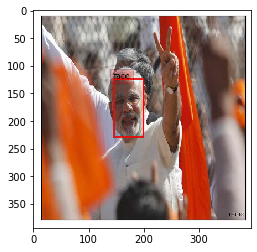

In [1]:
pic1 = imageio.imread('C:/Users/LENOVO/Face_Detection/output_test/2_Demonstration_Political_Rally_2_800_gt.jpg')
plt.imshow(pic1)

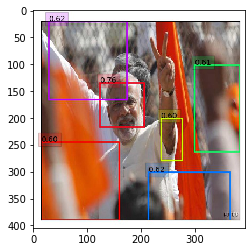

In [2]:
pic2 = imageio.imread('C:/Users/LENOVO/Face_Detection/output_test/2_Demonstration_Political_Rally_2_800.jpg')
plt.imshow(pic2)

##### Images with bounding box prediction when confidence was set at 63% 

(Predicted images are free from false bounding box triggers at 63% confidence)

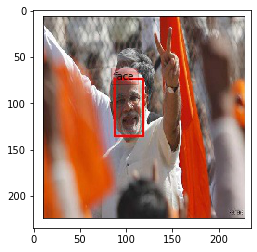

In [24]:
pic1 = imageio.imread('C:/Users/LENOVO/Face_Detection/output_test/2_Demonstration_Political_Rally_2_800_gt.jpg')
plt.imshow(pic1)

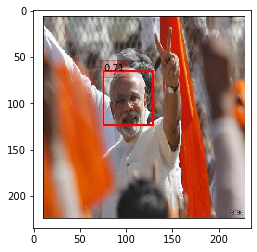

In [25]:
pic2 = imageio.imread('C:/Users/LENOVO/Face_Detection/output_test/2_Demonstration_Political_Rally_2_800.jpg')
plt.imshow(pic2)

## Conclusions

1. There are some false triggers when confidence threshold is set lower (60%). 

2. Some face detections are missed when confidence threshold is set higher (63%). 

3. Two possible ways to improve results are: 
    a) Including larger dataset for training, i.e. wider_train_v1.npy instead of wider_train_small.npy
    b) Tweaking the hyper-parameters and increasing number of epochs etc. 